In [1]:
# 내 코드로 전체 교체

In [2]:
from tensorflow.compat.v1 import ConfigProto

from tensorflow.compat.v1 import InteractiveSession



config = ConfigProto()

config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)


In [3]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ee1ahwgh
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ee1ahwgh
  Stored in directory: /tmp/pip-ephem-wheel-cache-onrfmr67/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [4]:
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import sys
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
PATH = './horse2zebra/data/'
BUFFER_SIZE = 500
EPOCHS = 40
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE
LAMBDA = 10

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def normalize(input_image):
    image = tf.cast(input_image, tf.float32)
    input_image = (image / 127.5) - 1

    return input_image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image



def preprocess_image_train(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image)
    #image = random_jitter(image) # <==== error : InvalidArgumentError: assertion failed: [Need value.shape >= size, got ] [286 286 1] [256 256 3]
    image = tf.cast(image, tf.float32)
    image = (image /127.5)-1
    return image

def preprocess_image_test(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image)
    #image = random_jitter(image)
    image = tf.cast(image, tf.float32)
    image = (image /127.5)-1
    return image

print(PATH)


data_dir = PATH
data_dir

import pathlib
data_root = pathlib.Path(data_dir)
data_root

for item in data_root.iterdir():
    print(item)
    

horse_image_paths = list(data_root.glob('trainA/*'))
horse_image_paths
horse_image_paths_str = [str(item) for item in horse_image_paths] 

zebra_image_paths = list(data_root.glob('trainB/*'))
zebra_image_paths
zebra_image_paths_str = [str(item) for item in zebra_image_paths] 

#horse_image_paths_str


./horse2zebra/data/
horse2zebra/data/testB
horse2zebra/data/n02391049_8008.jpg
horse2zebra/data/testA
horse2zebra/data/trainB
horse2zebra/data/trainA


In [7]:
len(zebra_image_paths_str)

1333

In [8]:
horse_image_paths_str[1]

'horse2zebra/data/trainA/n02381460_4371.jpg'

In [9]:
def except_from_list(list):
    length = len(list)
    for i in range(1327):
        img = tf.io.read_file(list[i])
        img = tf.image.decode_jpeg(img)
        if img.shape!=[256,256,3]:
            print('{}'.format(list[i]))
            list.remove(list[i])
    #print('{}'.format(img.shape))

In [10]:
except_from_list(zebra_image_paths_str)

horse2zebra/data/trainB/n02391049_226.jpg
horse2zebra/data/trainB/n02391049_9726.jpg
horse2zebra/data/trainB/n02391049_2757.jpg
horse2zebra/data/trainB/n02391049_2361.jpg
horse2zebra/data/trainB/n02391049_2341.jpg
horse2zebra/data/trainB/n02391049_7503.jpg


In [11]:

horse_path_ds = tf.data.Dataset.from_tensor_slices(horse_image_paths_str)
zebra_path_ds = tf.data.Dataset.from_tensor_slices(zebra_image_paths_str)

# h_ds = horse_path_ds.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)
# z_ds = zebra_path_ds.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)

train_horses = horse_path_ds.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = zebra_path_ds.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)



# h_ds = h_ds.take(10)
# h_ds = h_ds.cache()
# h_ds = h_ds.shuffle(buffer_size=BUFFER_SIZE)
# h_ds = h_ds.repeat()
# h_ds = h_ds.batch(BATCH_SIZE)
# train_horses = h_ds.prefetch(buffer_size=AUTOTUNE)

# z_ds = z_ds.take(10)
# z_ds = z_ds.cache()
# z_ds = z_ds.shuffle(buffer_size=BUFFER_SIZE)
# z_ds = z_ds.repeat()
# z_ds = z_ds.batch(BATCH_SIZE)
# train_zebras = z_ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_horses

<BatchDataset shapes: (None, None, None, None), types: tf.float32>

In [13]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

# Build the Generator

In [14]:
def downsample(filters, size, stride, applybatchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if applybatchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    #result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [15]:
def upsample(filters, size, stride, applybatchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=stride, padding='same',
                                              kernel_initializer=initializer, use_bias=False))
    if applybatchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [16]:
def residual_block(filters):
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters, size, stride=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.Conv2D(filters, size, stride=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    
    return result

In [17]:
def gen_XtoY():
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    stack = [
        downsample(64,7,1), #(none,256,256,64)
        downsample(128,3,2), #(..,128,128,128)
        downsample(256,3,2), #(...,64,64,256)
#         res_block(256,(3,3)),
#         res_block(256,(3,3)),
#         res_block(256,(3,3)),
#         res_block(256,(3,3)),
#         res_block(256,(3,3)),
#         res_block(256,(3,3)),
        upsample(128,3,2), #(...128,128,128)
        upsample(64,3,2), #(...,256,256,64)
        downsample(3,7,1), #(..,,)
    ]
    
    for i in stack:
        x = i(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Build the Discriminator

In [18]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [19]:
def disc_X():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    stack = [
        downsample(64,4,2),
        downsample(128,4,2),
        downsample(256,4,2),
        downsample(512,4,2),
        downsample(1,4,1),
    ]
    
    for i in stack:
        x = i(x)
        
    x = tf.keras.activations.sigmoid(x)
        
    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
gen_z = gen_XtoY()
gen_h = gen_XtoY()
disc_h = disc_X()
disc_z = disc_X()


In [21]:
disc_h.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_48 (Sequential)   (None, None, None, 64)    3328      
_________________________________________________________________
sequential_49 (Sequential)   (None, None, None, 128)   131584    
_________________________________________________________________
sequential_50 (Sequential)   (None, None, None, 256)   525312    
_________________________________________________________________
sequential_51 (Sequential)   (None, None, None, 512)   2099200   
_________________________________________________________________
sequential_52 (Sequential)   (None, None, None, 1)     8196      
_________________________________________________________________
tf_op_layer_Sigmoid (TensorF [(None, None, None, 1)]   0   

# Loss function and optimizer

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def cycle_loss(A, ABA):
    #cycle_loss_a = loss_object(A, ABA)
    #cycle_loss_b = loss_object(B, BAB)
    
    cycle_loss = tf.reduce_mean(tf.abs(A - ABA))

    return LAMBDA*cycle_loss

In [24]:
def generator_loss(img):
    gen_loss = loss_object(tf.ones_like(img), img)
    return gen_loss

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    disc_total_loss = real_loss + generated_loss

    return disc_total_loss/2

In [26]:
generator_optimizer_z = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_optimizer_h = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_optimizer_h = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer_z = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Generate Image

In [27]:
def generate_images(model, test_input):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10,10))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i]) #plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Train

In [28]:
def progress_bar(n):
    bar = ''
    bar += '['
    for i in range(22):
        if i<n/10:
            bar += '='
        elif i==n/10:
            bar += '>'
        else:
            bar += '-'
    bar += ']'
    return bar

In [29]:
@tf.function
def train_step(real_h, real_z):
    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape:
        fake_z = gen_z(real_h, training=True)
        fake_h = gen_h(real_z, training=True)
        
        cyc_h = gen_h(fake_z, training=True)
        cyc_z = gen_z(fake_h, training=True)
        
        disc_real_h = disc_h(real_h, training=True)
        disc_fake_h = disc_h(fake_h, training=True)
        disc_real_z = disc_z(real_z, training=True)
        disc_fake_z = disc_z(fake_z, training=True)
        
        
        #loss calc
        
        total_gen_loss_h = generator_loss(fake_h) + cycle_loss(real_h, cyc_h)
        total_gen_loss_z = generator_loss(fake_z) + cycle_loss(real_z, cyc_z)
        
        total_disc_loss_h = discriminator_loss(disc_real_h, disc_fake_h)
        total_disc_loss_z = discriminator_loss(disc_real_z, disc_fake_z)
        
        
        
    gen_z_grad = gen_tape.gradient(total_gen_loss_z, gen_z.trainable_variables)
    gen_h_grad = gen_tape.gradient(total_gen_loss_h, gen_h.trainable_variables)
    disc_h_grad = disc_tape.gradient(total_disc_loss_h, disc_h.trainable_variables)###
    disc_z_grad = disc_tape.gradient(total_disc_loss_z, disc_z.trainable_variables)

    generator_optimizer_z.apply_gradients(zip(gen_z_grad, gen_z.trainable_variables))
    generator_optimizer_h.apply_gradients(zip(gen_h_grad, gen_h.trainable_variables))
    discriminator_optimizer_h.apply_gradients(zip(disc_h_grad, disc_h.trainable_variables))
    discriminator_optimizer_z.apply_gradients(zip(disc_z_grad, disc_z.trainable_variables))
        

In [30]:
def train():
         for epoch in range(EPOCHS):

            n = 0
            for img_A, img_B in tf.data.Dataset.zip((train_horses, train_zebras)):
                
                train_step(img_A, img_B)
                n += 1
                if n%10 == 0:
                    print('{}'.format(progress_bar(n)), end='\r')
            
            clear_output(wait=True)
            generate_images(gen_z, sample_horse)
            print('EPOCH : {}'.format(epoch+1))

W0627 17:33:42.958843 140204222297920 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0627 17:33:42.973646 140204222297920 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


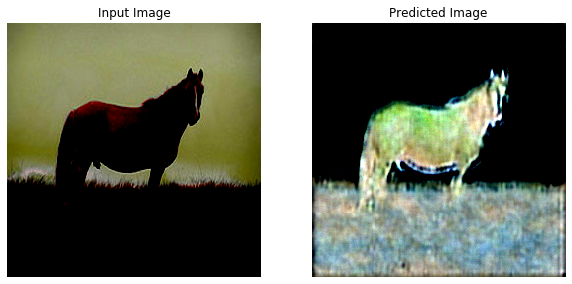

EPOCH : 7


KeyboardInterrupt: 

In [31]:
train()